In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

# Set the style of seaborn
sns.set_style("whitegrid")

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

#setting the random seed for reproducibility
np.random.seed(42)

In [88]:
# loading the dataset
data = pd.read_csv('ab_data.csv')
countries = pd.read_csv('countries.csv')

In [89]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [91]:
data.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [92]:
# Mean value of the 'converted' column
conversion_rate = data['converted'].mean()
print(f"Overall conversion rate: {conversion_rate:.4f}")

Overall conversion rate: 0.1197


In [93]:
count_newpage_treatment = len(data[(data['landing_page'] == 'new_page') & (data['group'] == 'control')])
print(f"Number of users in the control group who saw the new page: {count_newpage_treatment}")

Number of users in the control group who saw the new page: 1928


In [94]:
count_oldpage_treatment = len(data[(data['landing_page'] == 'old_page') & (data['group'] == 'treatment')])
print(f"Number of users in the treatment group who saw the old page: {count_oldpage_treatment}")

Number of users in the treatment group who saw the old page: 1965


In [95]:
total_data_inconsistent = count_newpage_treatment + count_oldpage_treatment
print(f"Total number of inconsistent data points: {total_data_inconsistent}")

Total number of inconsistent data points: 3893


The rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page. 

Need to create a new dataset.

In [96]:
df1 = data[(data['landing_page'] == 'new_page') & (data['group'] == 'treatment')]
df2 = data[(data['landing_page'] == 'old_page') & (data['group'] == 'control')]

data_clean = pd.concat([df1, df2])

In [97]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [98]:
data_clean[(data_clean['landing_page'] == 'new_page') & (data_clean['group'] == 'control')].shape[0]

0

In [99]:
data_clean.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [100]:
data_clean[data_clean.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


For user_id = 773192.

All things are similar except timestamp so by making timestamp equal to each other and then we can drop the duplicated 
row

In [101]:
# There are 2 duplicated user_id's in the data_clean dataframe. We will drop one of them to keep only unique user_id's.
data_clean['timestamp'].replace('2017-01-14 02:55:59.590927', '2017-01-09 05:37:58.781806', inplace=True)


In [102]:
# After replacing the timestamp of the duplicated user_id, we will drop the duplicate to keep only unique user_id's in the data_clean dataframe.
data_clean.drop_duplicates(keep= 'first', inplace=True)

In [103]:
# Probability of an individual converting regardless of the page they receive
overall_conversion_rate = data_clean['converted'].mean()
print(f"Overall conversion rate: {overall_conversion_rate:.4f}")

# Probability of converting given that an individual was in the control group
control_conversion_rate = data_clean[data_clean['group'] == 'control']['converted'].mean()
print(f"Conversion rate for control group: {control_conversion_rate:.4f}")

# Probability of converting given that an individual was in the treatment group
treatment_conversion_rate = data_clean[data_clean['group'] == 'treatment']['converted'].mean()
print(f"Conversion rate for treatment group: {treatment_conversion_rate:.4f}")


Overall conversion rate: 0.1196
Conversion rate for control group: 0.1204
Conversion rate for treatment group: 0.1188


There is a little higher number of people that converted in the control group as compared with reatment group.
The percentage of converted in the control group is 12.04% and converted in the treatment group is 11.88%.

##### Because of the time stamp associated with each event, could technically run a hypothesis test 

- Null Hypotheses: if p-value is less than 5%, the old page has a higher chance of converting users.
- Alternative Hypotheses: if p-value is equal to or greater than 5%, then the new page has a higher chance of converting users.

In [104]:
n_new = data_clean[data_clean['landing_page'] == 'new_page'].shape[0]
n_old = data_clean[data_clean['landing_page'] == 'old_page'].shape[0]
print(f"Number of users who received the new page: {n_new}")
print(f"Number of users who received the old page: {n_old}")


Number of users who received the new page: 145310
Number of users who received the old page: 145274


We assume the pnew = pold and start the hypothesis testing.

In [105]:
#Assuming both the p valyues to be the same as the overall conversion rate under the null hypothesis
p_new = overall_conversion_rate
p_old = overall_conversion_rate

# Simulating 10,000 instances of n_new and n_old conversions based on the overall conversion rate
diff = treatment_conversion_rate - control_conversion_rate
print(f"Observed difference in conversion rates (p_new - p_old): {diff:.4f}")

Observed difference in conversion rates (p_new - p_old): -0.0016


In [106]:
# Simulate the null hypothesis by generating 10,000 new conversion rates for both groups using the overall conversion rate
# For the new page group, we will generate 10,000 conversion rates based on the overall conversion rate and the number of users in the new page group (n_new).

# Simulating the conversion rates for the new page group under the null hypothesis
new_page_converted = np.random.choice(2, size=n_new, p=[p_new, 1 - p_new])

# Simulating the conversion rates for the old page group under the null hypothesis
old_page_converted = np.random.choice(2, size=n_old, p=[p_old, 1 - p_old])

# Calculate the conversion rates for both groups
new_page_conversion_rate = new_page_converted.mean()
old_page_conversion_rate = old_page_converted.mean()


# Calculate the difference in conversion rates between the new page and old page groups
simulated_p_diff = new_page_conversion_rate - old_page_conversion_rate
print(f"Simulated difference in conversion rates (p_new - p_old) under the null hypothesis: {simulated_p_diff:.4f}")

Simulated difference in conversion rates (p_new - p_old) under the null hypothesis: -0.0005


In [107]:
# Generate synthetic data for A/B testing
n_users = 10000

old_mean = []
new_mean = []
p_diff = []

for i in range(10000):

    # Simulating the conversion rates for the new page group under the null hypothesis
    new_page_converted = np.random.choice(2, size=n_new, p=[p_new, 1 - p_new])
    
    # Simulating the conversion rates for the old page group under the null hypothesis
    old_page_converted = np.random.choice(2, size=n_old, p=[p_old, 1 - p_old])
    
    # Calculate the conversion rates for both groups
    new_page_conversion_rate = new_page_converted.mean()
    old_page_conversion_rate = old_page_converted.mean()
    
    # Calculate the difference in conversion rates between the new page and old page groups
    simulated_p_diff = new_page_conversion_rate - old_page_conversion_rate
    
    # Append the results to the lists
    new_mean.append(new_page_conversion_rate)
    old_mean.append(old_page_conversion_rate)
    p_diff.append(simulated_p_diff)


C:\Users\saila\AppData\Local\Temp\ipykernel_1968\143740554.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


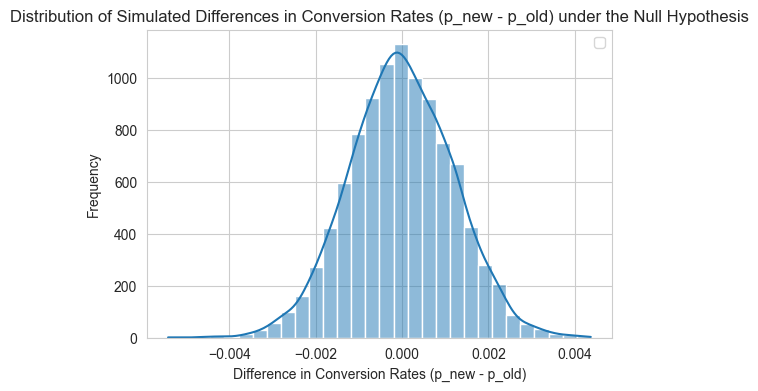

In [108]:
# Plotting the distribution of the simulated differences in conversion rates
plt.figure(figsize=(6, 4))
sns.histplot(p_diff, bins=30, kde=True)
plt.title('Distribution of Simulated Differences in Conversion Rates (p_new - p_old) under the Null Hypothesis')
plt.xlabel('Difference in Conversion Rates (p_new - p_old)')
plt.ylabel('Frequency')
plt.legend()
plt.show()  


In [109]:
actual_diff = control_conversion_rate - treatment_conversion_rate
print(f"Observed difference in conversion rates (p_new - p_old): {actual_diff:.4f}")

(p_diff > actual_diff).mean()
print(f"P-value: {(p_diff > actual_diff).mean():.4f}")


Observed difference in conversion rates (p_new - p_old): 0.0016
P-value: 0.0935


Our p-value is exceeds the critical value of 0.05 in this case and so we fail to reject the null hypothesis, we cannot assume the new page converts more users than the old page.

In [110]:
print("Total number of visitors in new page who converted:", n_new)
print("Total number of visitors in old page who converted:", n_old)


Total number of visitors in new page who converted: 145310
Total number of visitors in old page who converted: 145274


In [111]:
convert_old = data_clean[(data_clean['landing_page'] == 'old_page') & (data_clean['converted'] == 1)].count()
convert_new = data_clean[(data_clean['landing_page'] == 'new_page') & (data_clean['converted'] == 1)].count()
print("Number of conversions in old page group:", convert_old)
print("Number of conversions in new page group:", convert_new)

Number of conversions in old page group: user_id         17489
timestamp       17489
group           17489
landing_page    17489
converted       17489
dtype: int64
Number of conversions in new page group: user_id         17264
timestamp       17264
group           17264
landing_page    17264
converted       17264
dtype: int64


In [112]:
z_score, p_value = sm.stats.proportions_ztest([convert_old['converted'], convert_new['converted']], [n_old, n_new])
print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")

Z-score: 1.3109
P-value: 0.1899


In [113]:
# Calculating the cumulative distribution function (CDF) for the z-score to find the probability of observing a z-score.
# As extreme as the one calculated under the null hypothesis
norm.cdf(z_score)

np.float64(0.9050583127590245)

In [114]:
norm.ppf(0.975)

np.float64(1.959963984540054)

### The Regression Part

"Does seeing the new page significantly change the probability of converting?"

In [115]:
#Creating column ab_page that sets the individual to 1 when it is of treatment group.
# Sets the individual to 0 when it is of control group.

data_clean[['ab_page', 'treatment']] = pd.get_dummies(data_clean['group'])

In [116]:
data_clean.head()

,user_id,timestamp,group,landing_page,converted,ab_page,treatment
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,True
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,False,True
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,False,True
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,False,True


In [117]:
data_clean['ab_page'] = data_clean['ab_page'].astype(int)
data_clean['treatment'] = data_clean['treatment'].astype(int)

In [118]:
data_clean['intercept'] = 1

In [119]:
model = sm.Logit(data_clean['converted'], data_clean[['intercept','ab_page']])

In [120]:
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:               8.077e-06
Time:                        14:08:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

In [131]:
np.exp(0.0150)

np.float64(1.015113064615719)

 Holding all other variables constant, the number of converted is 1.015 times more likely to be converted than those that are not converted. This means that the old page and new page are both equal in chance of converting users. We should not assume that the new page is better than the old page.

The p-value found in the logistic regression model(0.19) is different than what we found earlier because our null and alternative hypthesis model assumed that there is an equal probability of the old and new page converting users.
In the logistic regression model, this is not the case. Also, the Logistic Regression performed is a two-tailed test, whereas the computation done in Part II is a one-tailed test.

In [121]:
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [122]:
countries[['CA', 'UK', 'US']] = pd.get_dummies(countries['country'])

In [123]:
data_countries = data_clean.join(countries.set_index('user_id'), on = "user_id")

In [124]:
data_countries['CA'] = data_countries['CA'].map({True:1, False: 0})
data_countries['UK'] = data_countries['UK'].map({True:1, False:0})
data_countries['US'] = data_countries['US'].map({True:1, False: 0})

In [125]:
data_countries.head()

,user_id,timestamp,group,landing_page,converted,ab_page,treatment,intercept,country,CA,UK,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0,1,1,CA,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0,1,1,CA,1,0,0


In [127]:
data_countries.groupby('country')['converted'].mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [128]:
data_countries['CA_abpage'] = data_countries['CA'] * data_countries['ab_page']
data_countries['UK_abpage'] = data_countries['UK'] * data_countries['ab_page']
data_countries['US_abpage'] = data_countries['US'] * data_countries['ab_page']

In [129]:
model2 = sm.Logit(data_countries['converted'], data_countries[['intercept', 'CA_abpage', 'UK_abpage', 'US_abpage']])

In [130]:
results2 = model2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 13 Feb 2026   Pseudo R-squ.:               9.383e-06
Time:                        14:15:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.5731
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
CA_abpage     -0.0002      0.037     -0.006      0.995      -0.073       0.073
UK_abpage      0.0115      0.018      0.639      0.523      -0.024       0.047
US_abpage      0.0173      0.013      1.374      0.170      -0.007       0.042
==============================================================================
"""

In [133]:
np.exp(results2.params)

intercept    0.134827
CA_abpage    0.999761
UK_abpage    1.011611
US_abpage    1.017439
dtype: float64

 By looking at the odds ratio of the interaction between country and ab_page, we have an equal chance of the ab_page converting users in each country(1.017, 1.012, 1.00). We thus fail to reject the null hypothesis; the new page does not convert more than the old page.